In [1]:
import numpy as np
import matplotlib.pyplot as plt
from src.plotting_convention import mark_subplots, simplify_axes

In [2]:
num_kernels = 2
tau_1 = 0.2
tau_2 = 1.0
dt = 0.1
kernel_length = 200
signal_length = 1000
num_spikes_per_kernel = 3

kernel_amps = np.array([0.75, 1.25])
spike_times = np.array([[35, 50, 70], 
                        [25, 50, 90]])

t_kernel = np.arange(kernel_length) * dt
t_signal = np.arange(signal_length) * dt

kernels = np.zeros((num_kernels, kernel_length))
firing_rates = np.zeros((num_kernels, signal_length))
phi = np.zeros(signal_length)

### Make kernels

In [3]:
# Because of causality, kernels should be zero before mid-point
tmid_idx = int(kernel_length/2)
t_ = t_kernel[:tmid_idx]
for k_idx in range(num_kernels):
    kernels[k_idx, tmid_idx:] = (-np.exp(-t_ / tau_1) + np.exp(-t_ / tau_2)) * kernel_amps[k_idx]

### Make firing rates

In [4]:
for s_idx in range(num_kernels):
    t_idxs = np.array([np.argmin(np.abs(t_signal - spiketime)) for spiketime in spike_times[s_idx]])
    firing_rates[s_idx, t_idxs] = 1
firing_rates /= dt*1e-3

### Make reference signal

In [5]:
for k_idx in range(num_kernels):
    phi_i = np.convolve(kernels[k_idx, ], firing_rates[k_idx], mode="same") * (dt*1e-3)
    phi += phi_i

### Make population kernel signal

In [6]:
avrg_kernel = np.average(kernels, axis=0)
pop_firing_rate =  np.average(firing_rates, axis=0)
phi_tilde = np.convolve(avrg_kernel, pop_firing_rate, mode="same") * (dt*1e-3) * num_kernels

### Plot results

<>:14: SyntaxWarning: invalid escape sequence '\D'
<>:14: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_448923/2082400815.py:14: SyntaxWarning: invalid escape sequence '\D'
  ax_fr = fig.add_subplot(413, ylabel="population rate\n(spikes / $\Delta t$)", xlim=xlim,


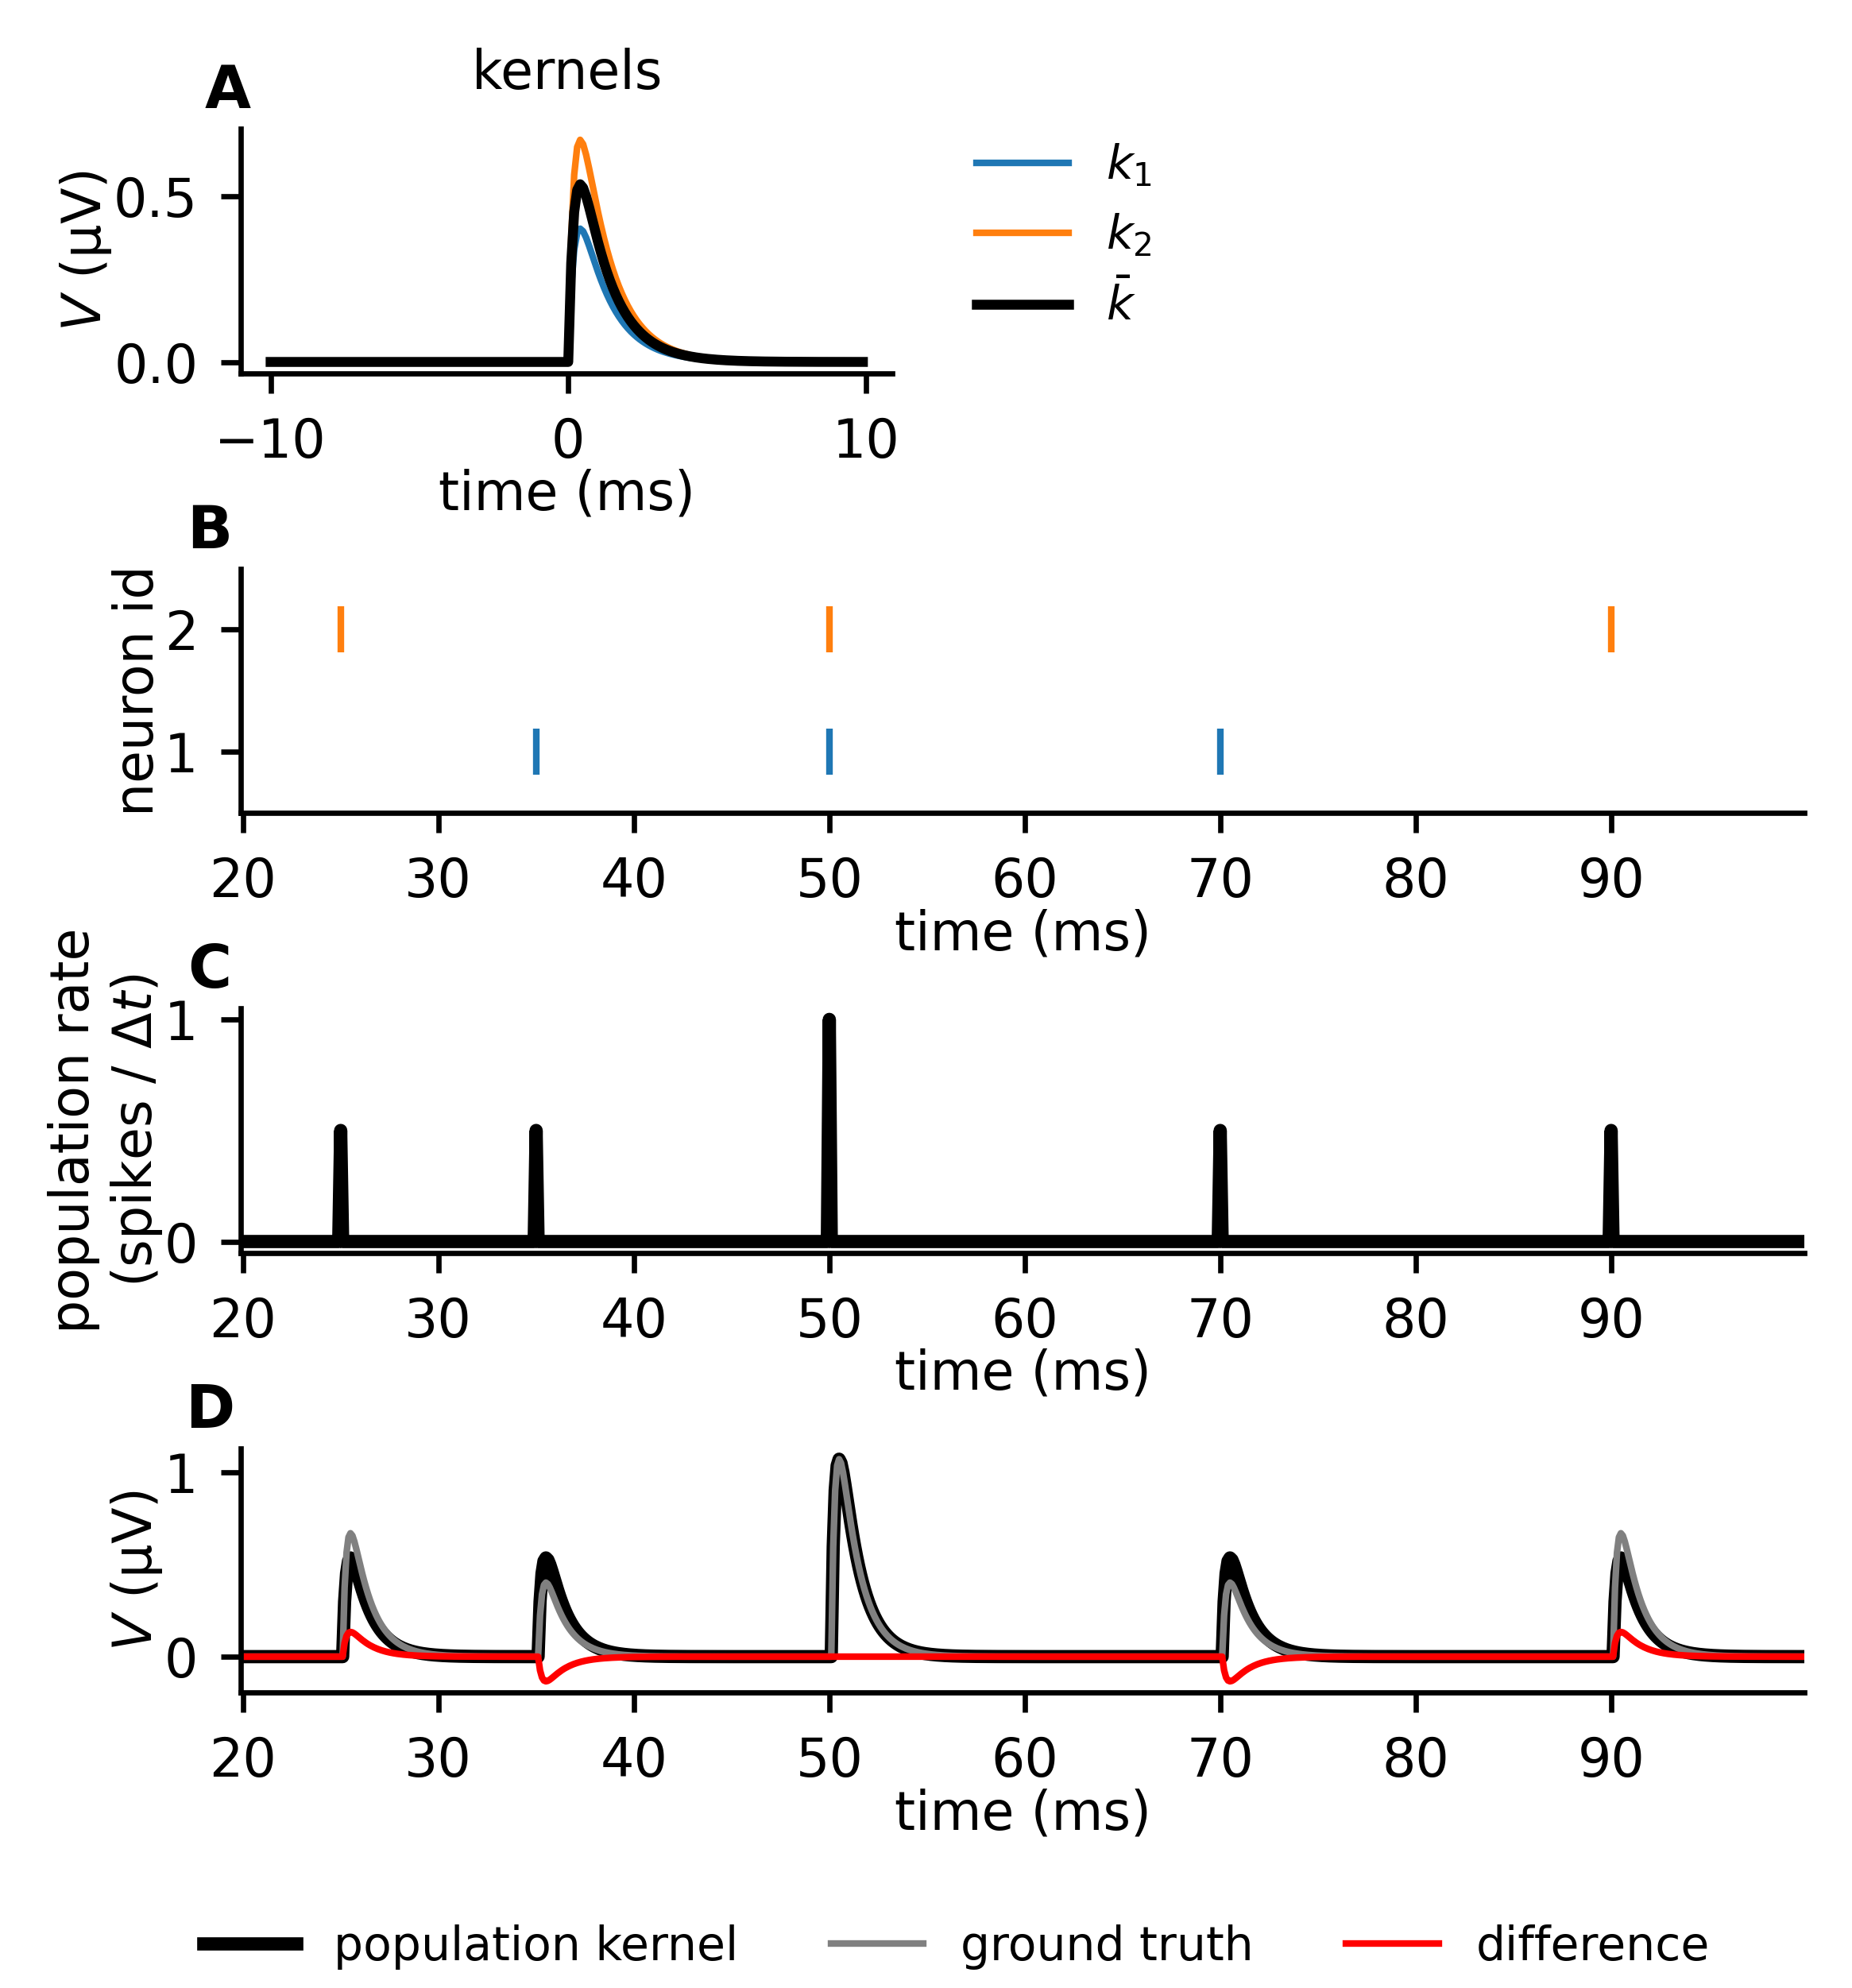

In [7]:
difference = phi - phi_tilde

xlim = [t_kernel[-1], t_signal[-1]]
plt.close("all")
fig = plt.figure(figsize=[4, 4])
fig.subplots_adjust(hspace=0.8, top=0.95, left=0.15, right=0.97, bottom=0.13)

ax_k = fig.add_subplot(421, title="kernels",
                       xlabel="time (ms)", ylabel=r"$V$ (µV)")
ax_sp = fig.add_subplot(412, ylabel="neuron id",
                        ylim=[0.5, num_kernels + 0.5], yticks=[1, 2], 
                        xlim=xlim,
                        xlabel="time (ms)")
ax_fr = fig.add_subplot(413, ylabel="population rate\n(spikes / $\Delta t$)", xlim=xlim,
                        xlabel="time (ms)")

ax_sig = fig.add_subplot(414, xlim=xlim, xlabel="time (ms)",
                         ylabel=r"$V$ (µV)")
kls = []
kl_names = []
for k_idx in range(num_kernels):
    kl, = ax_k.plot(t_kernel - t_kernel[tmid_idx], kernels[k_idx, ], lw=1)
    spike_time_idxs = np.where(firing_rates[k_idx] > 0.1)[0]
    ax_sp.plot(t_signal[spike_time_idxs],
               np.ones(len(spike_time_idxs)) + k_idx, '|', ms=7)  
    kls.append(kl)
    kl_names.append(f"$k_{k_idx + 1}$")
    
l, = ax_k.plot(t_kernel - t_kernel[tmid_idx], avrg_kernel, lw=1.5, c='k')
ax_fr.plot(t_signal, pop_firing_rate * dt*1e-3, lw=2, c='k')

kls.append(l)
kl_names.append(r"$\bar{k}$")

l1, = ax_sig.plot(t_signal, phi_tilde, lw=2, c='k', ls='-')
l2, = ax_sig.plot(t_signal, phi, c='gray')
l3, = ax_sig.plot(t_signal, difference, c='r')

ax_k.legend(kls, kl_names, frameon=False, loc=(1.1, 0.1))

fig.legend([l1, l2, l3], [r"population kernel",
                          r"ground truth",
                          r"difference"],
              frameon=False, ncol=3, loc=(0.1, 0.0))
simplify_axes(fig.axes)
mark_subplots(fig.axes, xpos=-0.02)

plt.savefig("toy_kernel_illustration.pdf")